# LSTM [THROUGH ONE-HOT ENCODING]

**Importing the necessary packages**

In [1]:
import nltk
import pandas as pd
import numpy as np
# The NLTK data package includes a pre-trained Punkt tokenizer for English.
# punkt had to be manually downloaded using the command below
# same with stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

!pip install deep_translator
from deep_translator import GoogleTranslator

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional, Input, Concatenate, TimeDistributed
from tensorflow.keras.utils import plot_model

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow as tf
tf.config.run_functions_eagerly(True)

**LOADING TRAIN, TEST AND VALIDATION INTO THE DATAFRAME**

In [4]:
train = pd.read_csv('/kaggle/input/translated-data-english/translated_data_english.tsv', sep='\t')
validation = pd.read_csv('/kaggle/input/translated-data-english-validation/translated_data_english_validation.tsv', sep='\t')
df_test = pd.read_csv('/kaggle/input/translated-data-english-test/translated_data_english_test.tsv', sep='\t')

In [5]:
original_df = pd.DataFrame()

**MERGING TRAIN, TEST AND VALIDATION INTO THE SINGLE DATAFRAME**

In [6]:
original_df = original_df.append(train, ignore_index=True)
original_df = original_df.append(df_test, ignore_index=True)
original_df = original_df.append(validation, ignore_index=True)

/tmp/ipykernel_28/2974941267.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  original_df = original_df.append(train, ignore_index=True)
/tmp/ipykernel_28/2974941267.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  original_df = original_df.append(df_test, ignore_index=True)
/tmp/ipykernel_28/2974941267.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  original_df = original_df.append(validation, ignore_index=True)


In [7]:
original_df.head()

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affilation,count_1,count_2,count_3,count_4,count_5,context,statement_removedpunctuation,nepali_translation,english_translation
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,When did the decline of coal start It started ...,कोइलाको पतन कहिले सुरु भयो यो प्राकृतिक ग्यास ...,When did the decline of coal begin? It began w...
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Hillary Clinton agrees with John McCain by vot...,हिलारी क्लिन्टनले जर्ज बुशलाई इरानमा शंकाको फा...,Hillary Clinton agreed with John McCain by vot...
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,Health care reform legislation is likely to ma...,स्वास्थ्य हेरचाह सुधार कानूनले नि: शुल्क लिंग ...,Health care reform legislation is likely to ma...
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,The economic turnaround started at the end of ...,मेरो कार्यकालको अन्त्यमा आर्थिक परिवर्तन सुरु भयो,"Towards the end of my tenure, the economic tra..."
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,The Chicago Bears have had more starting quart...,शिकागो बियर्सले विगत दुई दशकहरूमा बर्खास्त गरि...,The Chicago Bears have had more starting quart...


In [8]:
original_df.shape

(12782, 17)

**LOWERING THE STRING**

In [9]:
original_df['english_translation'] = original_df['english_translation'].str.lower()

**REMOVING PUNCUTATION FROM "english_translation"**

In [10]:
import string
def removepunctuation(sentence):
   new_text = sentence.replace("—", " ") # "—" in the text was not equivalent to "-" so we replcaed "—" with a space
   print 
  #iterate over every single character to see if it is a punctuation or not, and then concatenate them using "join"
   punctuationfree="".join([i for i in new_text if i not in string.punctuation])
   return punctuationfree

In [11]:
original_df["statement_removedpunctuation"] = original_df['english_translation'].apply(lambda x : removepunctuation(x))

In [12]:
original_df.head()

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affilation,count_1,count_2,count_3,count_4,count_5,context,statement_removedpunctuation,nepali_translation,english_translation
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,when did the decline of coal begin it began wi...,कोइलाको पतन कहिले सुरु भयो यो प्राकृतिक ग्यास ...,when did the decline of coal begin? it began w...
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hillary clinton agreed with john mccain by vot...,हिलारी क्लिन्टनले जर्ज बुशलाई इरानमा शंकाको फा...,hillary clinton agreed with john mccain by vot...
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legislation is likely to ma...,स्वास्थ्य हेरचाह सुधार कानूनले नि: शुल्क लिंग ...,health care reform legislation is likely to ma...
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,towards the end of my tenure the economic tran...,मेरो कार्यकालको अन्त्यमा आर्थिक परिवर्तन सुरु भयो,"towards the end of my tenure, the economic tra..."
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,the chicago bears have had more starting quart...,शिकागो बियर्सले विगत दुई दशकहरूमा बर्खास्त गरि...,the chicago bears have had more starting quart...


**"statement_removed punctuation" contains the 'statement' column, with lowercased characters and removed punctuation**

**TOKENIZING THE "statement_removed punctuation"**

In [13]:
original_df["english_translation_tokenized"] = original_df["statement_removedpunctuation"].apply(word_tokenize)

In [14]:
original_df.head()

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affilation,count_1,count_2,count_3,count_4,count_5,context,statement_removedpunctuation,nepali_translation,english_translation,english_translation_tokenized
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,when did the decline of coal begin it began wi...,कोइलाको पतन कहिले सुरु भयो यो प्राकृतिक ग्यास ...,when did the decline of coal begin? it began w...,"[when, did, the, decline, of, coal, begin, it,..."
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hillary clinton agreed with john mccain by vot...,हिलारी क्लिन्टनले जर्ज बुशलाई इरानमा शंकाको फा...,hillary clinton agreed with john mccain by vot...,"[hillary, clinton, agreed, with, john, mccain,..."
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legislation is likely to ma...,स्वास्थ्य हेरचाह सुधार कानूनले नि: शुल्क लिंग ...,health care reform legislation is likely to ma...,"[health, care, reform, legislation, is, likely..."
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,towards the end of my tenure the economic tran...,मेरो कार्यकालको अन्त्यमा आर्थिक परिवर्तन सुरु भयो,"towards the end of my tenure, the economic tra...","[towards, the, end, of, my, tenure, the, econo..."
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,the chicago bears have had more starting quart...,शिकागो बियर्सले विगत दुई दशकहरूमा बर्खास्त गरि...,the chicago bears have had more starting quart...,"[the, chicago, bears, have, had, more, startin..."


**A new column, "english_translation_tokenized", is created and it contains the tokens generated from the sentence.**

**Generate a list of stop words for stopword removal**

In [15]:
stop_words = stopwords.words('english')

**REMOVING STOP WORDS FROM "english_translation_tokenized"**

In [16]:
def stopwordremoval(words):
    preprocessed_tokens = []
    for i in words:
        # Remove stopwords and empty strings while keeping words separated by space
        post_removal = [word for word in i.split() if word.lower() not in stop_words]
        filtered_string = " ".join(post_removal).strip()
        if filtered_string:
            preprocessed_tokens.append(filtered_string)
    # Combine the preprocessed tokens into a single string
    combined_string = " ".join(preprocessed_tokens)
    return combined_string

In [17]:
original_df["english_translation_stopwords"] = original_df["english_translation_tokenized"].apply(stopwordremoval)

In [18]:
import spacy

**Used to load the English language model of spaCy**

In [19]:
nlp = spacy.load("en_core_web_sm")

**PERFORMING LEMMETIZATION ON "english_translation_stopwords".
Lemmatization is the process of reducing a word to its base or root form.**

In [20]:
def lemmetization(text):
    doc = nlp(text)
    lemmetized = []
    for token in doc:
        lemmetized.append(token.lemma_)
    return " ".join(lemmetized)


In [21]:
original_df["preprocessed_english"] = original_df["english_translation_stopwords"].apply(lemmetization)

**VALUE COUNTS FOR LABELS. OUR DATASET CONSIST OF SIX LABELS, WHICH WE WOULD BE REDUCING TO 3**

In [22]:
original_df['label'].value_counts()

half-true      2626
false          2504
mostly-true    2453
barely-true    2101
true           2051
pants-fire     1047
Name: label, dtype: int64

**WE HAVE COMBINED:**
1. "true" and "mostly-true" to represent as true
2. "false" and "pants-fire" to represent as fasle
3. "half-true" and "barely-true" to represent as vague

In [23]:
original_df.replace(to_replace=["true", "mostly-true"],
           value="true", inplace=True)
original_df.replace(to_replace=["false", "pants-fire"],
           value="false", inplace=True)
original_df.replace(to_replace=["half-true", "barely-true"],
           value="vague", inplace=True)

**HERE WE CAN SEE OUR LABEL CONSIST OF THREE CLASES**

In [24]:
original_df.value_counts('label')

label
vague    4727
true     4504
false    3551
dtype: int64

**Now we can see that the labels have been updated**

In [25]:
original_df.head()

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affilation,count_1,count_2,count_3,count_4,count_5,context,statement_removedpunctuation,nepali_translation,english_translation,english_translation_tokenized,english_translation_stopwords,preprocessed_english
0,10540.json,vague,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,when did the decline of coal begin it began wi...,कोइलाको पतन कहिले सुरु भयो यो प्राकृतिक ग्यास ...,when did the decline of coal begin? it began w...,"[when, did, the, decline, of, coal, begin, it,...",decline coal begin began natural gas layoff be...,decline coal begin begin natural gas layoff be...
1,324.json,true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hillary clinton agreed with john mccain by vot...,हिलारी क्लिन्टनले जर्ज बुशलाई इरानमा शंकाको फा...,hillary clinton agreed with john mccain by vot...,"[hillary, clinton, agreed, with, john, mccain,...",hillary clinton agreed john mccain voting give...,hillary clinton agree john mccain voting give ...
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legislation is likely to ma...,स्वास्थ्य हेरचाह सुधार कानूनले नि: शुल्क लिंग ...,health care reform legislation is likely to ma...,"[health, care, reform, legislation, is, likely...",health care reform legislation likely mandate ...,health care reform legislation likely mandate ...
3,9028.json,vague,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,towards the end of my tenure the economic tran...,मेरो कार्यकालको अन्त्यमा आर्थिक परिवर्तन सुरु भयो,"towards the end of my tenure, the economic tra...","[towards, the, end, of, my, tenure, the, econo...",towards end tenure economic transformation began,towards end tenure economic transformation begin
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,the chicago bears have had more starting quart...,शिकागो बियर्सले विगत दुई दशकहरूमा बर्खास्त गरि...,the chicago bears have had more starting quart...,"[the, chicago, bears, have, had, more, startin...",chicago bears starting quarterbacks past ten y...,chicago bear start quarterback past ten year t...


**And there are now 3 values for 'label' instead of 6**

In [26]:
wordcounts = original_df['preprocessed_english'].apply(lambda x: len(x))

In [27]:
original_df['preprocessed_english'][0]

'decline coal begin begin natural gas layoff begin administration president george w bush'

In [28]:
wordcounts

0         88
1         76
2         78
3         48
4         89
        ... 
12777     51
12778     46
12779     50
12780    135
12781     87
Name: preprocessed_english, Length: 12782, dtype: int64

In [29]:
original_df['label'].unique()

array(['vague', 'true', 'false'], dtype=object)

**Creates a copy of "preprocessed_english" column and assigns it to a new variable called "corpus"**

In [30]:
corpus = original_df['preprocessed_english'].copy()

In [31]:
label = original_df['label'].copy()

**WE HAVE TAKEN VOCABULARY_SIZE AS 5000**

In [32]:
voc_size = 5000

**CREATE ONE HOT REPRSENTATION OF THE CORPUS**

In [33]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

**To ensure that all sequences in a given dataset have the same length by padding**

In [34]:
sent_length=5000
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 4047 2718 2804]
 [   0    0    0 ... 1334 1071  670]
 [   0    0    0 ... 2501 1841  175]
 ...
 [   0    0    0 ... 3365 3252 4436]
 [   0    0    0 ... 3252  205 4522]
 [   0    0    0 ... 2915 2423 4788]]


In [35]:
X_final=np.array(embedded_docs)
y_final=np.array(label)

In [36]:
y_final[1:10]

array(['true', 'false', 'vague', 'true', 'vague', 'vague', 'vague',
       'true', 'true'], dtype=object)

**Preprocesses the target variable by applying one-hot encoding using OneHotEncoder**

In [37]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()
ohe = OneHotEncoder()
# Fit and transform the target variable
# y_training = label_encoder.fit_transform(y_train)
y_training = ohe.fit_transform(y_final.reshape(-1,1)).todense()

In [38]:
y_training[1:10]

matrix([[0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.]])

**SPLITTING INTO TEST,TRAIN AS test_size=0.33**

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_training, test_size=0.33)

In [40]:
X_train.shape

(8563, 5000)

In [41]:
y_train.shape

(8563, 3)

# LSTM MODEL

In [42]:
## Creating model
embedding_vector_features= 1000
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
#model.add(Dropout(0.5))
model.add(LSTM(20))
model.add(Dropout(0.3))
model.add(Dense(50, input_shape=(sent_length,)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 1000)        5000000   
                                                                 
 lstm (LSTM)                 (None, 20)                81680     
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 50)                1050      
                                                                 
 batch_normalization (BatchN  (None, 50)               200       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                        

In [43]:
history = model.fit(X_train,y_train,epochs=50, validation_split=0.2)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


215/215 [==============================] - 55s 228ms/step - loss: 1.2281 - accuracy: 0.3464 - val_loss: 1.0913 - val_accuracy: 0.3748
Epoch 2/50
215/215 [==============================] - 49s 227ms/step - loss: 1.1412 - accuracy: 0.3590 - val_loss: 1.0873 - val_accuracy: 0.3800
Epoch 3/50
215/215 [==============================] - 48s 222ms/step - loss: 1.0952 - accuracy: 0.4149 - val_loss: 1.0943 - val_accuracy: 0.3783
Epoch 4/50
215/215 [==============================] - 48s 225ms/step - loss: 1.0415 - accuracy: 0.4704 - val_loss: 1.1098 - val_accuracy: 0.3929
Epoch 5/50
215/215 [==============================] - 48s 224ms/step - loss: 0.9848 - accuracy: 0.5165 - val_loss: 1.1579 - val_accuracy: 0.4011
Epoch 6/50
215/215 [==============================] - 49s 230ms/step - loss: 0.8993 - accuracy: 0.5812 - val_loss: 1.2617 - val_accuracy: 0.3812
Epoch 7/50
215/215 [==============================] - 49s 228ms/step - loss: 0.8151 - accuracy: 0.6399 - val_loss: 1.3835 - val_accuracy: 0.3

**As we can see train loss is significantly lower than validation loss. It indicates that our model is overfitting.**
**And the training accuracy is also higher than validaion accuracy. So, the model struggles to performwell on new data.**

In [44]:
X_train.shape

(8563, 5000)

In [45]:
score, acc = model.evaluate(X_test, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

132/132 [==============================] - 11s 82ms/step - loss: 5.6597 - accuracy: 0.3747
Test score: 5.659717082977295
Test accuracy: 0.3747333586215973


**The evaluation of the model on the test data shows a test loss of 5.65 and a test accuracy of around 0.3747. The model correctly predicted the labels for about 37% of the test instances.
The low test accuracy shows that it is not performing well on unseen data, and this is an example of overfitting.**

In [46]:
'''
vocab_size = 5000

model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=X_train.shape[1]))  # Embedding layer
# model.add(Dropout(rate=0.4))
model.add(LSTM(units=4))
# model.add(Dropout(rate=0.4))
model.add(Dense(units=50,  activation='relu'))
# model.add(Dropout(rate=0.5))
model.add(Dense(units=3, activation='sigmoid'))

model.summary()


adam=tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(
    X_train, 
    y_train, 
    validation_data=[X_valid, y_valid],
    batch_size=16,
    epochs = 5
)

'''

"\nvocab_size = 5000\n\nmodel = Sequential()\nmodel.add(Embedding(vocab_size, 128, input_length=X_train.shape[1]))  # Embedding layer\n# model.add(Dropout(rate=0.4))\nmodel.add(LSTM(units=4))\n# model.add(Dropout(rate=0.4))\nmodel.add(Dense(units=50,  activation='relu'))\n# model.add(Dropout(rate=0.5))\nmodel.add(Dense(units=3, activation='sigmoid'))\n\nmodel.summary()\n\n\nadam=tf.keras.optimizers.Adam(learning_rate=0.0001)\n\nmodel.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics = ['accuracy'])\n\nhistory = model.fit(\n    X_train, \n    y_train, \n    validation_data=[X_valid, y_valid],\n    batch_size=16,\n    epochs = 5\n)\n\n"

# PLOT FOR ACCURACY AND LOSS

In [47]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

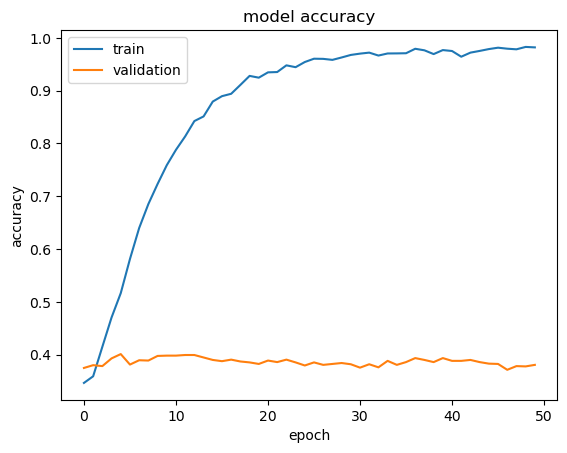

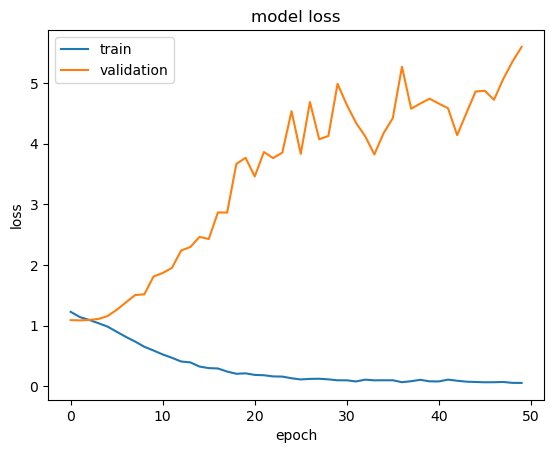

In [48]:
plot_history(history)

**Analyzing the training accuracy, the model's performance shows improvememnt from 37% to 98% in 50 epochs.**

**Now, observing the graph above, we can that there is no significant improvement of model's performance on validation set. The validation accuracy is fluctuating in between 36 to 40%.**  


In [49]:
X_test

array([[   0,    0,    0, ..., 1647, 4203,  702],
       [   0,    0,    0, ..., 1236,  108, 3726],
       [   0,    0,    0, ..., 3311,  188,  695],
       ...,
       [   0,    0,    0, ..., 2365,  314, 2847],
       [   0,    0,    0, ..., 1039, 3674, 3674],
       [   0,    0,    0, ..., 1669, 1415,  771]], dtype=int32)

In [50]:
y_test

matrix([[0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]])

In [51]:
y_pred = model.predict(X_test)

132/132 [==============================] - 10s 72ms/step


In [52]:
y_pred.shape

(4219, 3)

In [53]:
y_pred

array([[9.9999869e-01, 9.5261498e-07, 3.7551442e-07],
       [9.9999547e-01, 3.8296248e-06, 7.3397149e-07],
       [4.6156431e-03, 9.5296526e-01, 4.2419147e-02],
       ...,
       [9.8486090e-08, 9.9999988e-01, 2.6838359e-08],
       [1.4549148e-03, 9.9176305e-06, 9.9853516e-01],
       [4.3196533e-02, 9.4221246e-01, 1.4590947e-02]], dtype=float32)

In [54]:
y_test_array = np.array(y_test)
y_test_array

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [55]:
y_pred_binary = (y_pred >= 0.5).astype(int)
y_pred_binary 

array([[1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0]])

# CLASSIFICATION REPORT 

In [56]:
print(classification_report(y_test_array,y_pred_binary))

              precision    recall  f1-score   support

           0       0.32      0.28      0.30      1149
           1       0.40      0.41      0.41      1485
           2       0.39      0.40      0.39      1585

   micro avg       0.37      0.37      0.37      4219
   macro avg       0.37      0.36      0.37      4219
weighted avg       0.37      0.37      0.37      4219
 samples avg       0.37      0.37      0.37      4219



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Through classification report we can see that:**
**Precision : It is the ratio of (true positive) / (true positive + false positive)**

* lets see the precision for label 0 i.e vague => From confusion matrix we can see that precision = 672 / (672 + 698 + 816) = 0.33, which shows that 33% of prediction for class vague were correct.
* Similary for label 1 i.e true, 42% of prediction were correct.
* For label 2 i.e false, 37% of predition were correct.

**Recall : It is the ratio of (true positive)/ (true positive + false negative)**
* The recall for class 0 (vague) is 0.36, indicating that 36% of the actual instances of class 1 were correctly identified by the model.
* The recall for class 1 (true) is 0.42, indicating that 42% of the actual instances of class 1 were correctly identified by the model.
* The recall for class 2 (false) is 0.12, indicating that 12% of the actual instances of class 1 were correctly identified by the model.

**The F1-score is the harmonic mean of precision and recall. It provides a balanced measure of the model's performance by considering both precision and recall.**

**Support represents the number of actual occurrences of each class in the test data.**
* vague = 1193
* true = 1490
* 1536

In [57]:
y_pred_flattened = np.argmax(y_pred_binary, axis=1)
confusion_mat = confusion_matrix(np.asarray(np.argmax(y_test, axis=1)), y_pred_flattened)
class_labels = ['vague', 'true', 'false']

# CONFUSION MATRIX

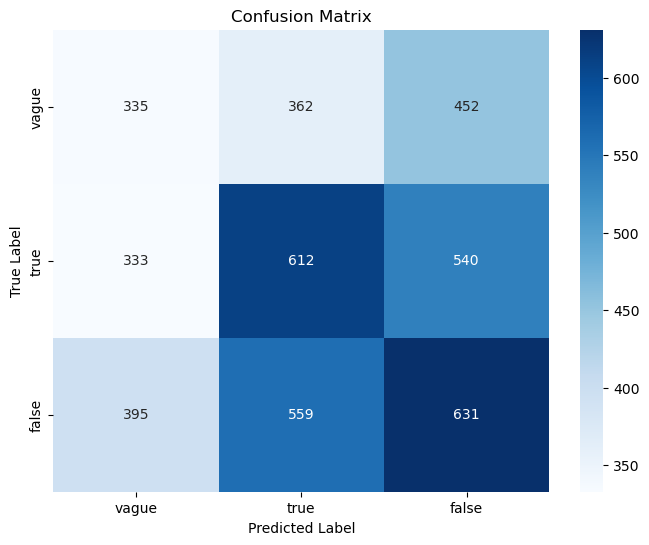

In [58]:
confusion_df = pd.DataFrame(confusion_mat, index=class_labels, columns=class_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Above matrix clearly shows the true and predcted label for each class.**

In [59]:
input_text="नागरिकता विधेयकमा कम क्षतिसहित संविधान ट्य्राकमा ल्याइयो, अब दुवै पक्ष शान्त हौं"

In [65]:
def fake_news_tester(nepali_news):
    english_translation = GoogleTranslator(source='auto', target="en").translate(nepali_news)
    # print(english_translation, "\n")
    english_translation_lower = english_translation.lower()
    english_tokenized = word_tokenize(english_translation_lower)
    # print(english_tokenized, "\n")
    english_no_stopwords = stopwordremoval(english_tokenized)
    english_lemmetized = lemmetization(english_no_stopwords)
    # print(english_lemmetized, "\n")
    onehot_text = one_hot(english_lemmetized, voc_size)
    sent_length = 5000
    input_embedded = pad_sequences([onehot_text],padding='pre',maxlen=sent_length)
    X_input = np.array(input_embedded)
    predictedlabely = model.predict(np.asarray(X_input))
    return ohe.inverse_transform(predictedlabely)

In [66]:
fake_news_tester("नागरिकता विधेयकमा कम क्षतिसहित संविधान ट्य्राकमा ल्याइयो, अब दुवै पक्ष शान्त हौं")

1/1 [==============================] - 0s 102ms/step


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


array([['true']], dtype=object)

In [ ]:
model.save('/kaggle/working/lstmmodel.h5')

In [68]:
from tensorflow.keras.models import load_model

# Load the saved model from file
loaded_model = load_model('/kaggle/input/lstmmodel/lstmmodel.h5')


In [69]:
def fake_news_tester_loadedmodel(nepali_news):
    english_translation = GoogleTranslator(source='auto', target="en").translate(nepali_news)
    # print(english_translation, "\n")
    english_translation_lower = english_translation.lower()
    english_tokenized = word_tokenize(english_translation_lower)
    # print(english_tokenized, "\n")
    english_no_stopwords = stopwordremoval(english_tokenized)
    english_lemmetized = lemmetization(english_no_stopwords)
    # print(english_lemmetized, "\n")
    onehot_text = one_hot(english_lemmetized, voc_size)
    sent_length = 5000
    input_embedded = pad_sequences([onehot_text],padding='pre',maxlen=sent_length)
    X_input = np.array(input_embedded)
    predictedlabely = loaded_model.predict(np.asarray(X_input))
    return ohe.inverse_transform(predictedlabely)

In [73]:
fake_news_tester_loadedmodel("विज्ञान र तकनीकमा नेपालले विश्वको मुख्य स्थान गठन गर्दै")

1/1 [==============================] - 0s 87ms/step


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


array([['false']], dtype=object)

In [74]:
fake_news_tester_loadedmodel("सरकारले नयाँ कानुनले अपाङ्गताको अवस्थालाई सुधार्ने कार्यक्रम सुरु")

1/1 [==============================] - 0s 87ms/step


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


array([['vague']], dtype=object)

In [75]:
fake_news_tester_loadedmodel("धितोपत्र बोर्डले दियो १८ नयाँ ब्रोकरलाई सञ्चालन अनुमति")

1/1 [==============================] - 0s 84ms/step


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


array([['true']], dtype=object)